# download dataset

In [ ]:
!wget https://cdn.iiith.talentsprint.com/CDSE_experiments_data/Industrial_Projects/movielens.zip

--2024-03-05 17:49:30--  https://cdn.iiith.talentsprint.com/CDSE_experiments_data/Industrial_Projects/movielens.zip
Resolving cdn.iiith.talentsprint.com (cdn.iiith.talentsprint.com)... 172.105.52.210
Connecting to cdn.iiith.talentsprint.com (cdn.iiith.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘movielens.zip’

movielens.zip       100%[===================>] 249.84M  11.5MB/s    in 18s     

2024-03-05 17:49:48 (14.1 MB/s) - ‘movielens.zip’ saved [261978986/261978986]



In [ ]:
!unzip -n /content/movielens.zip

Archive:  /content/movielens.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


#import Libararies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from scipy.spatial import distance
keras.utils.set_random_seed(812)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

#Load Data

In [ ]:
movie_df = pd.read_csv('/content/ml-25m/movies.csv')
pd.set_option('display.max_columns',None)
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
user_df = pd.read_csv('/content/ml-25m/ratings.csv')

pd.set_option('display.max_columns',None)
user_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
# merge movie information and user
df = pd.merge(movie_df, user_df, on='movieId')
pd.set_option('display.max_columns',None)
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517


In [ ]:
df['movieId'].unique()

array([     1,      2,      3, ..., 209163, 209169, 209171])

In [ ]:
# consider only first 500 movies
df = df[df['movieId']<500]

In [ ]:

df['userId'].unique()

array([     2,      3,      4, ...,  29182, 102023, 111885])

In [ ]:
# consider only first 500 users
df = df[df['userId']<500]

In [ ]:
len(df)

9384

#data analysis

In [ ]:
# movie dataset Analysis
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
genres = pd.Series(''.join(movie_df['genres'].to_list()).split('|'))

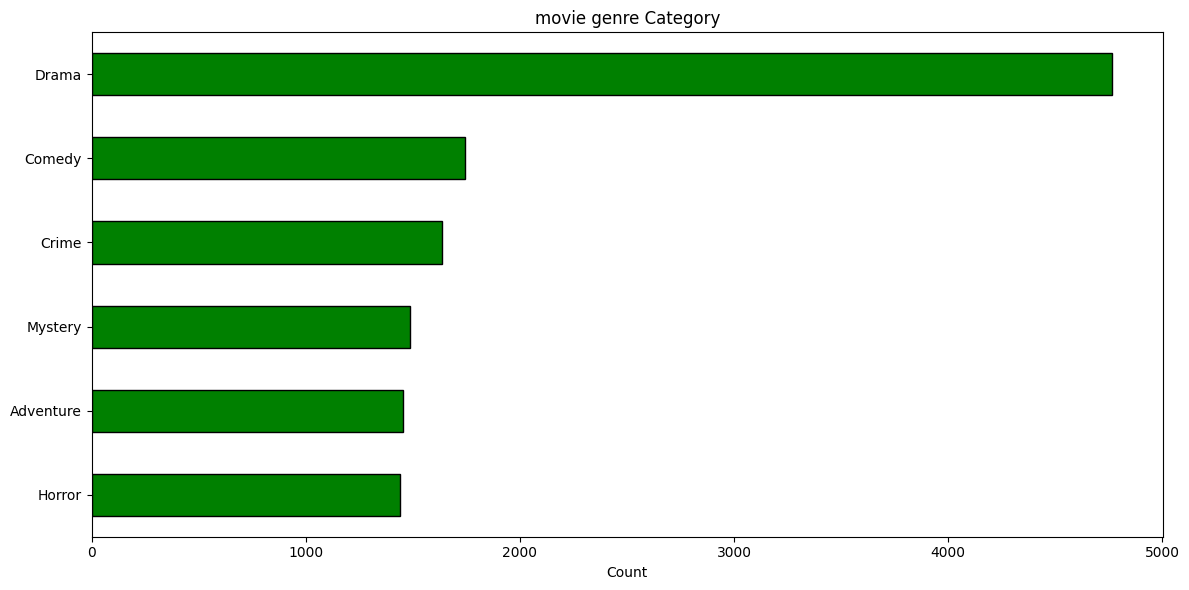

In [ ]:
#  major movie categories

plt.figure(figsize=(12, 6))

genres.value_counts()[:6].iloc[::-1].plot(kind='barh', color='green', edgecolor='black')

plt.title('movie genre Category')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

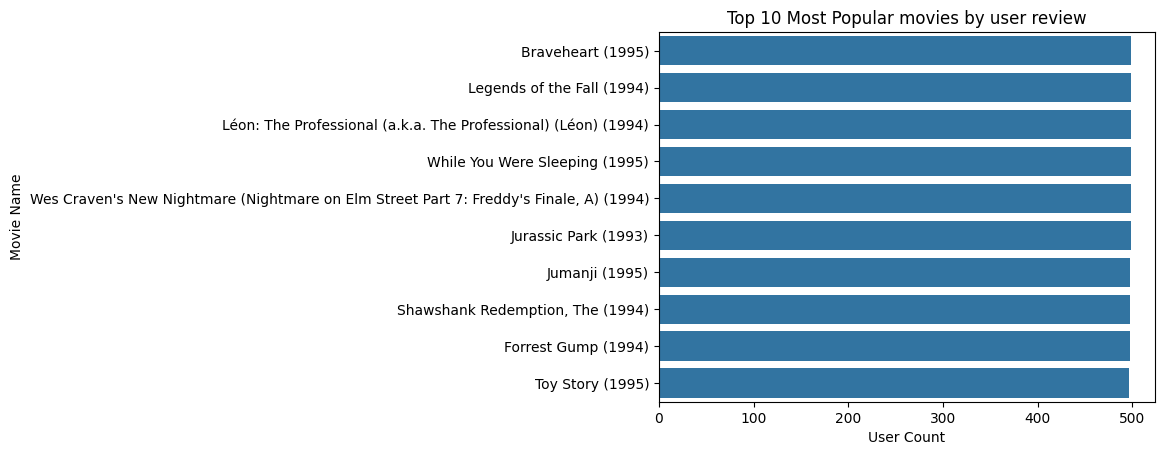

In [ ]:
# most popular movies
sns.barplot(x='userId', y='title', data=df.nlargest(10, 'userId'))
plt.title('Top 10 Most Popular movies by user review')
plt.xlabel('User Count')
plt.ylabel('Movie Name')
plt.show()

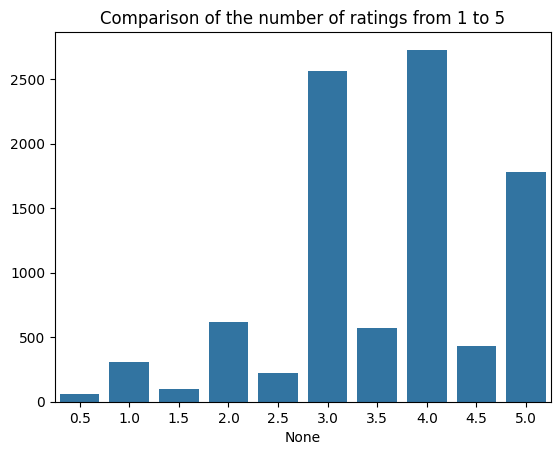

In [ ]:
rating_count = df['rating'].value_counts().sort_index()
sns.barplot(x=rating_count.index,
            y=rating_count.values).set_title('Comparison of the number of ratings from 1 to 5');

In [ ]:
# average rating for each movie
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(20)

title
Total Eclipse (1995)                                                                                  5.000000
The Journey of August King (1995)                                                                     5.000000
Guardian Angel (1994)                                                                                 5.000000
Kids of the Round Table (1995)                                                                        5.000000
Strawberry and Chocolate (Fresa y chocolate) (1993)                                                   5.000000
Endless Summer 2, The (1994)                                                                          5.000000
Across the Sea of Time (1995)                                                                         5.000000
Nobody Loves Me (Keiner liebt mich) (1994)                                                            5.000000
Once Upon a Time... When We Were Colored (1995)                                                       5.00

#Data Preprocessing

In [ ]:
movie_df['genres'] = movie_df['genres'].str.split('|')
movie_df['genres'] = movie_df['genres'].fillna('').astype('str')
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,Jumanji (1995),"['Adventure', 'Children', 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']"
4,5,Father of the Bride Part II (1995),['Comedy']


In [ ]:
# create a new dataframe
data = df.copy()
data = data.drop('timestamp',axis=1)
data.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0


In [ ]:
# check for null values
data.isna().any()

movieId    False
title      False
genres     False
userId     False
rating     False
dtype: bool

In [ ]:
# since genres column  may contain null values, check the count of null values
data['genres'].isna().sum()

0

In [ ]:
data = data[data['rating']>3]

In [ ]:
# remove punctuations
def remove_punctuations(text):
    return re.sub('[^a-zA-Z]', ' ', text)

data['genres'] = data['genres'].apply(remove_punctuations)
data.head(3)

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,2,3.5
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3,4.0
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,5,4.0


In [ ]:
data[['userId', 'movieId']] = data[['userId', 'movieId']].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5507 entries, 0 to 3323743
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  5507 non-null   object 
 1   title    5507 non-null   object 
 2   genres   5507 non-null   object 
 3   userId   5507 non-null   object 
 4   rating   5507 non-null   float64
dtypes: float64(1), object(4)
memory usage: 258.1+ KB


In [ ]:
enc1 = LabelEncoder()
data['userId'] = enc1.fit_transform(data['userId'])

enc2 = LabelEncoder()
data['movieId'] = enc2.fit_transform(data['movieId'])

# Collaborative Filtering


In [ ]:
noOfusers = data['userId'].nunique()
noOfmovies = data['movieId'].nunique()

print('unique users:', noOfusers)
print('unique movies:', noOfmovies)

unique users: 470
unique movies: 340


In [ ]:
# create deep learning model
ndim = 180
# User
user_id = layers.Input(shape=(1,))
U = layers.Embedding(noOfusers, ndim)(user_id)
U = layers.Flatten()(U)

# movie
movi = layers.Input(shape=(1,))
P = layers.Embedding(noOfmovies, ndim)(movi)
P = layers.Flatten()(P)

concat = layers.concatenate([U, P])
dense_1 = layers.Dense(512, activation='relu')(concat)
dense_1 = layers.Dense(256, activation='relu')(dense_1)
dense_1 = layers.BatchNormalization()(dense_1)
dropout_1 = layers.Dropout(0.5)(dense_1)
dense_2 = layers.Dense(128)(dropout_1)
dense_2 = layers.BatchNormalization()(dense_2)
dropout_2 = layers.Dropout(0.5)(dense_2)
final = layers.Dense(1)(dropout_2)

model_1 = Model(inputs=[user_id, movi], outputs=final)

model_1.compile(optimizer=Adam(0.00001),
              loss='mean_squared_error')

model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 180)               84600     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 180)               61200     ['input_2[0][0]']             
                                                                                              

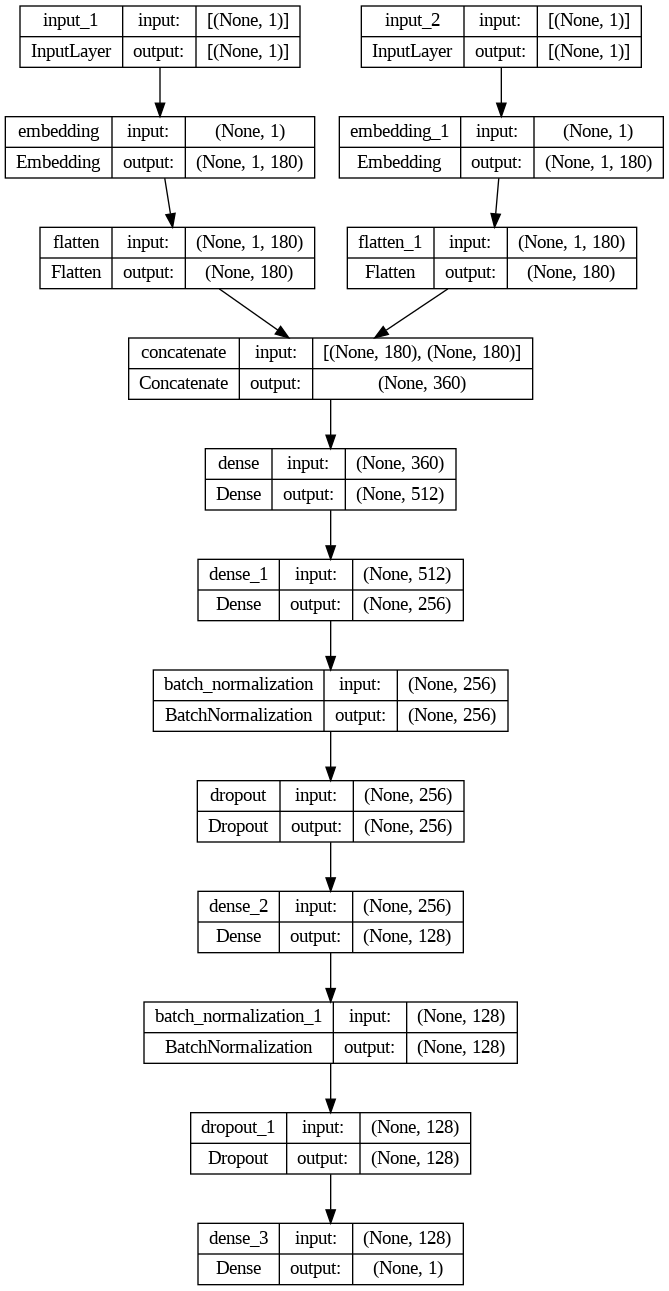

In [ ]:
plot_model(model_1,show_shapes=True,to_file='deep learning model for Collaborative Filtering.png')

In [ ]:
X = data.drop(['rating','title','genres'], axis=1)
Y = data['rating']

In [ ]:
xtrain,xtest1,ytrain,ytest1 = train_test_split(X,Y,test_size=0.3,random_state=23)

In [ ]:
xtrain.isnull().any()

movieId    False
userId     False
dtype: bool

In [ ]:
history_1 = model_1.fit([xtrain['userId'],xtrain['movieId']],
                    ytrain,
                    batch_size=128,
                    epochs=500,
                    validation_split=0.4)

Epoch 1/500
19/19 [==============================] - 12s 212ms/step - loss: 23.6931 - val_loss: 18.4433
Epoch 2/500
19/19 [==============================] - 2s 77ms/step - loss: 22.9869 - val_loss: 18.4660
Epoch 3/500
19/19 [==============================] - 1s 36ms/step - loss: 23.5398 - val_loss: 18.4592
Epoch 4/500
19/19 [==============================] - 0s 9ms/step - loss: 23.0546 - val_loss: 18.4123
Epoch 5/500
19/19 [==============================] - 1s 34ms/step - loss: 23.6837 - val_loss: 18.4151
Epoch 6/500
19/19 [==============================] - 0s 18ms/step - loss: 23.1094 - val_loss: 18.4037
Epoch 7/500
19/19 [==============================] - 0s 27ms/step - loss: 22.5649 - val_loss: 18.3819
Epoch 8/500
19/19 [==============================] - 1s 34ms/step - loss: 22.6503 - val_loss: 18.2906
Epoch 9/500
19/19 [==============================] - 0s 11ms/step - loss: 22.8639 - val_loss: 18.3358
Epoch 10/500
19/19 [==============================] - 0s 11ms/step - loss: 22.780

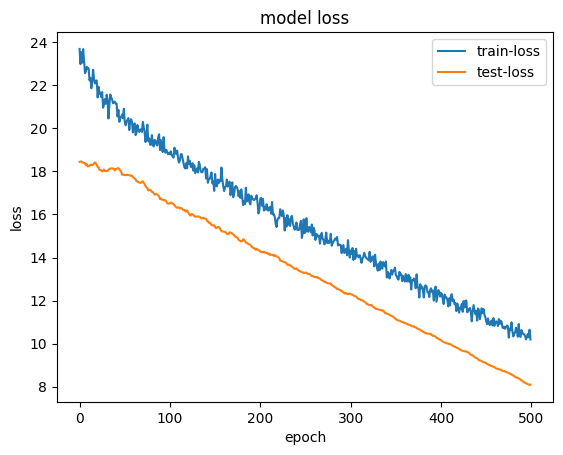

In [ ]:

# "Loss"
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'test-loss'], loc='upper right')
plt.show()

In [ ]:
userId = int(23)
user_ratings = data[data['userId'] == userId]
recommendation = data[~data['movieId'].isin(user_ratings['movieId'])][['movieId']].drop_duplicates()
recommendation['userId'] = userId
recommendation['predicted_rating'] =model_1.predict([recommendation['userId'],recommendation['movieId']])
recommendation = recommendation.merge(data[['title','movieId']],on='movieId')
recommendation = recommendation.drop_duplicates()
recommendation = recommendation.sort_values(by='predicted_rating', ascending=False).reset_index()
# recommend 5 products
results = recommendation[['title']].copy()
results = results.rename(columns={'title':'recommended movies'})
results.head(5)

10/10 [==============================] - 0s 2ms/step


,recommended movies
0,Bed of Roses (1996)
1,Fresh (1994)
2,Beautiful Girls (1996)
3,I Love Trouble (1994)
4,The Journey of August King (1995)


# Content-based Filtering

In [ ]:
# Feature extraction
# Bag-Of-Words
def feature_extract(data):
  bow = CountVectorizer(max_features=120)
  fet = bow.fit_transform(list(data['genres'])).toarray()
  N = 120-fet.shape[1]
  fet = np.hstack([fet,np.zeros((fet.shape[0],N))])
  return fet

fet = feature_extract(data)

In [ ]:
# lstm model
lstm_model = keras.Sequential()
lstm_model.add(layers.SimpleRNN(3, return_sequences=True,input_shape=(1,120)))
lstm_model.add(layers.LSTM(2,return_sequences=True))
lstm_model.add(layers.SimpleRNN(2))
lstm_model.add(layers.Dense(512))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(512))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dense(256))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(128))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1))
lstm_model.compile(optimizer=Adam(0.00001),
              loss='mean_squared_error')
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 3)              372       
                                                                 
 lstm (LSTM)                 (None, 1, 2)              48        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 2)                 10        
                                                                 
 dense_4 (Dense)             (None, 512)               1536      
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                        

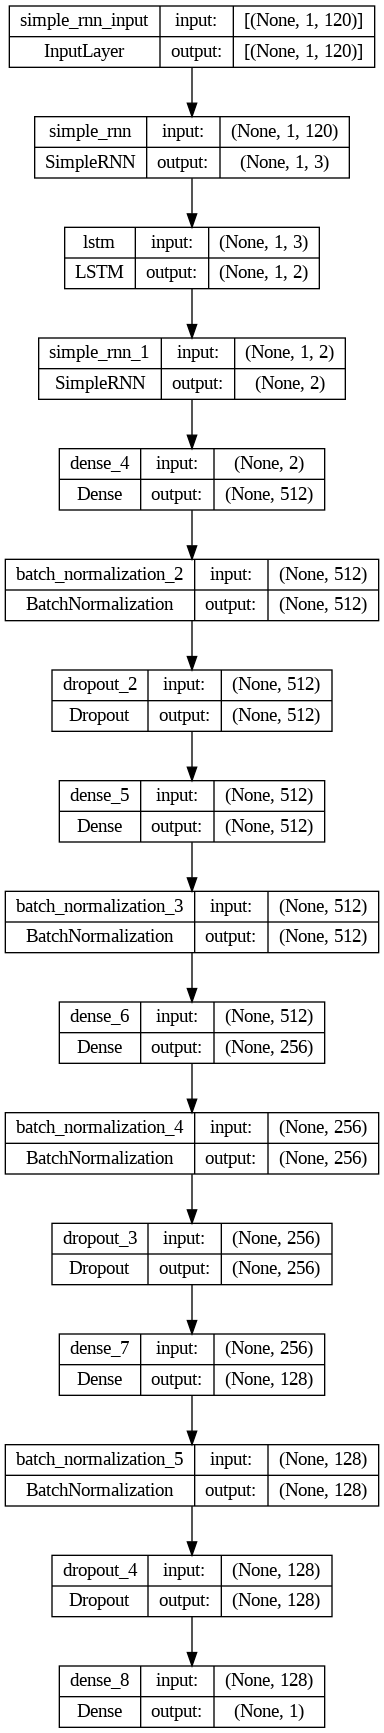

In [ ]:
plot_model(lstm_model,show_shapes=True,to_file='deep learning model for content based Filtering.png')

In [ ]:
inputdata_text = np.array(fet)
target = np.array(data['rating'])

In [ ]:
# Model training
x_train, x_temp, y_train, y_temp = train_test_split(inputdata_text, target, test_size=0.4, random_state=36)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=32)

x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))
x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[1]))


history_2 = lstm_model.fit(x_train,y_train,epochs=100, batch_size=128,validation_data=(x_val, y_val))


Epoch 1/100
26/26 [==============================] - 10s 70ms/step - loss: 20.4344 - val_loss: 18.7399
Epoch 2/100
26/26 [==============================] - 1s 24ms/step - loss: 20.2960 - val_loss: 18.7576
Epoch 3/100
26/26 [==============================] - 0s 14ms/step - loss: 20.0565 - val_loss: 18.7603
Epoch 4/100
26/26 [==============================] - 0s 15ms/step - loss: 20.0195 - val_loss: 18.7438
Epoch 5/100
26/26 [==============================] - 0s 14ms/step - loss: 19.7711 - val_loss: 18.7217
Epoch 6/100
26/26 [==============================] - 0s 15ms/step - loss: 19.7852 - val_loss: 18.6654
Epoch 7/100
26/26 [==============================] - 0s 16ms/step - loss: 19.6239 - val_loss: 18.6399
Epoch 8/100
26/26 [==============================] - 0s 14ms/step - loss: 19.6831 - val_loss: 18.5605
Epoch 9/100
26/26 [==============================] - 0s 13ms/step - loss: 19.4803 - val_loss: 18.4970
Epoch 10/100
26/26 [==============================] - 0s 14ms/step - loss: 19.590

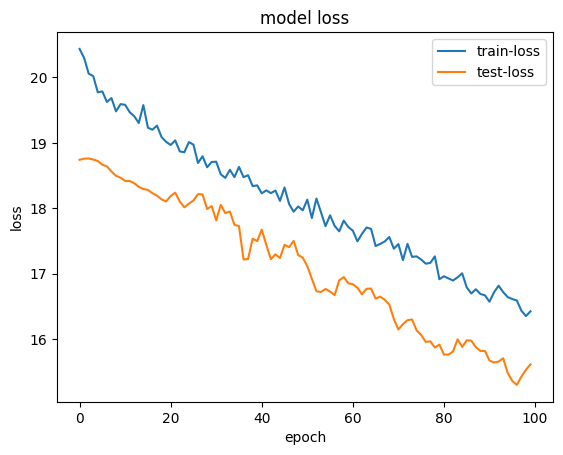

In [ ]:
# "Loss"
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'test-loss'], loc='upper right')
plt.show()

In [ ]:
userId = int(23)
user_ratings = data[data['userId'] == userId]
user_fet = feature_extract(user_ratings)
distances = distance.cdist(user_fet, fet, "cosine")[0]
index = np.argsort(distances)
data2 = data.iloc[index]
data2 = data2.drop_duplicates(subset='title', keep="first")
user_inputdata_text = feature_extract(data2)
user_inputdata_text = user_inputdata_text.reshape((user_inputdata_text.shape[0],1,user_inputdata_text.shape[1]))
recommendation2 = data2.copy()
recommendation2['predicted_rating'] =lstm_model.predict(user_inputdata_text)
recommendation2 = recommendation2.merge(data[['title','movieId']],on='movieId')
recommendation2 = recommendation2.drop_duplicates()
recommendation2 = recommendation2.sort_values(by='predicted_rating', ascending=False).reset_index()
# recommend 5 movies
results = recommendation2[['title_x']].copy()
results = results.rename(columns={'title_x':'recommended movies'})
results.head(5)

11/11 [==============================] - 1s 5ms/step


,recommended movies
0,"Usual Suspects, The (1995)"
1,Devil in a Blue Dress (1995)
2,Hackers (1995)
3,Hard Target (1993)
4,Seven (a.k.a. Se7en) (1995)


#Hybrid model

In [ ]:
ndim = 180
# User
user_id = layers.Input(shape=(1,))
U = layers.Embedding(noOfusers, ndim)(user_id)
U = layers.Flatten()(U)

# movie
movi = layers.Input(shape=(1,))
P = layers.Embedding(noOfmovies, ndim)(movi)
P = layers.Flatten()(P)

# features
feature = layers.Input(shape=(1,120))
F = layers.SimpleRNN(3, return_sequences=True)(feature)
F = layers.LSTM(2,return_sequences=True)(F)
F = layers.SimpleRNN(2)(F)
F = layers.Dense(512)(F)
F = layers.BatchNormalization()(F)
F = layers.Dropout(0.2)(F)
F = layers.Dense(512)(F)
F = layers.BatchNormalization()(F)
F = layers.Dense(256)(F)
F = layers.BatchNormalization()(F)
F = layers.Dense(128)(F)
F = layers.Flatten()(F)

concat = layers.concatenate([U, P,F])
dense_layer = layers.Dense(512, activation='relu')(concat)
dense_layer = layers.Dense(512, activation='relu')(dense_layer)
dense_layer = layers.Dropout(0.2)(dense_layer)
dense_layer = layers.Dense(256, activation='relu')(dense_layer)
dense_layer = layers.BatchNormalization()(dense_layer)
dense_2 = layers.Dense(128, activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_layer)
final = layers.Dense(1)(dropout_2)

model_hybrid = Model(inputs=[user_id, movi,feature], outputs=final)

model_hybrid.compile(optimizer=Adam(0.00001),
              loss='mean_squared_error')

model_hybrid.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1, 120)]             0         []                            
                                                                                                  
 simple_rnn_2 (SimpleRNN)    (None, 1, 3)                 372       ['input_5[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 1, 2)                 48        ['simple_rnn_2[0][0]']        
                                                                                                  
 simple_rnn_3 (SimpleRNN)    (None, 2)                    10        ['lstm_1[0][0]']              
                                                                                            

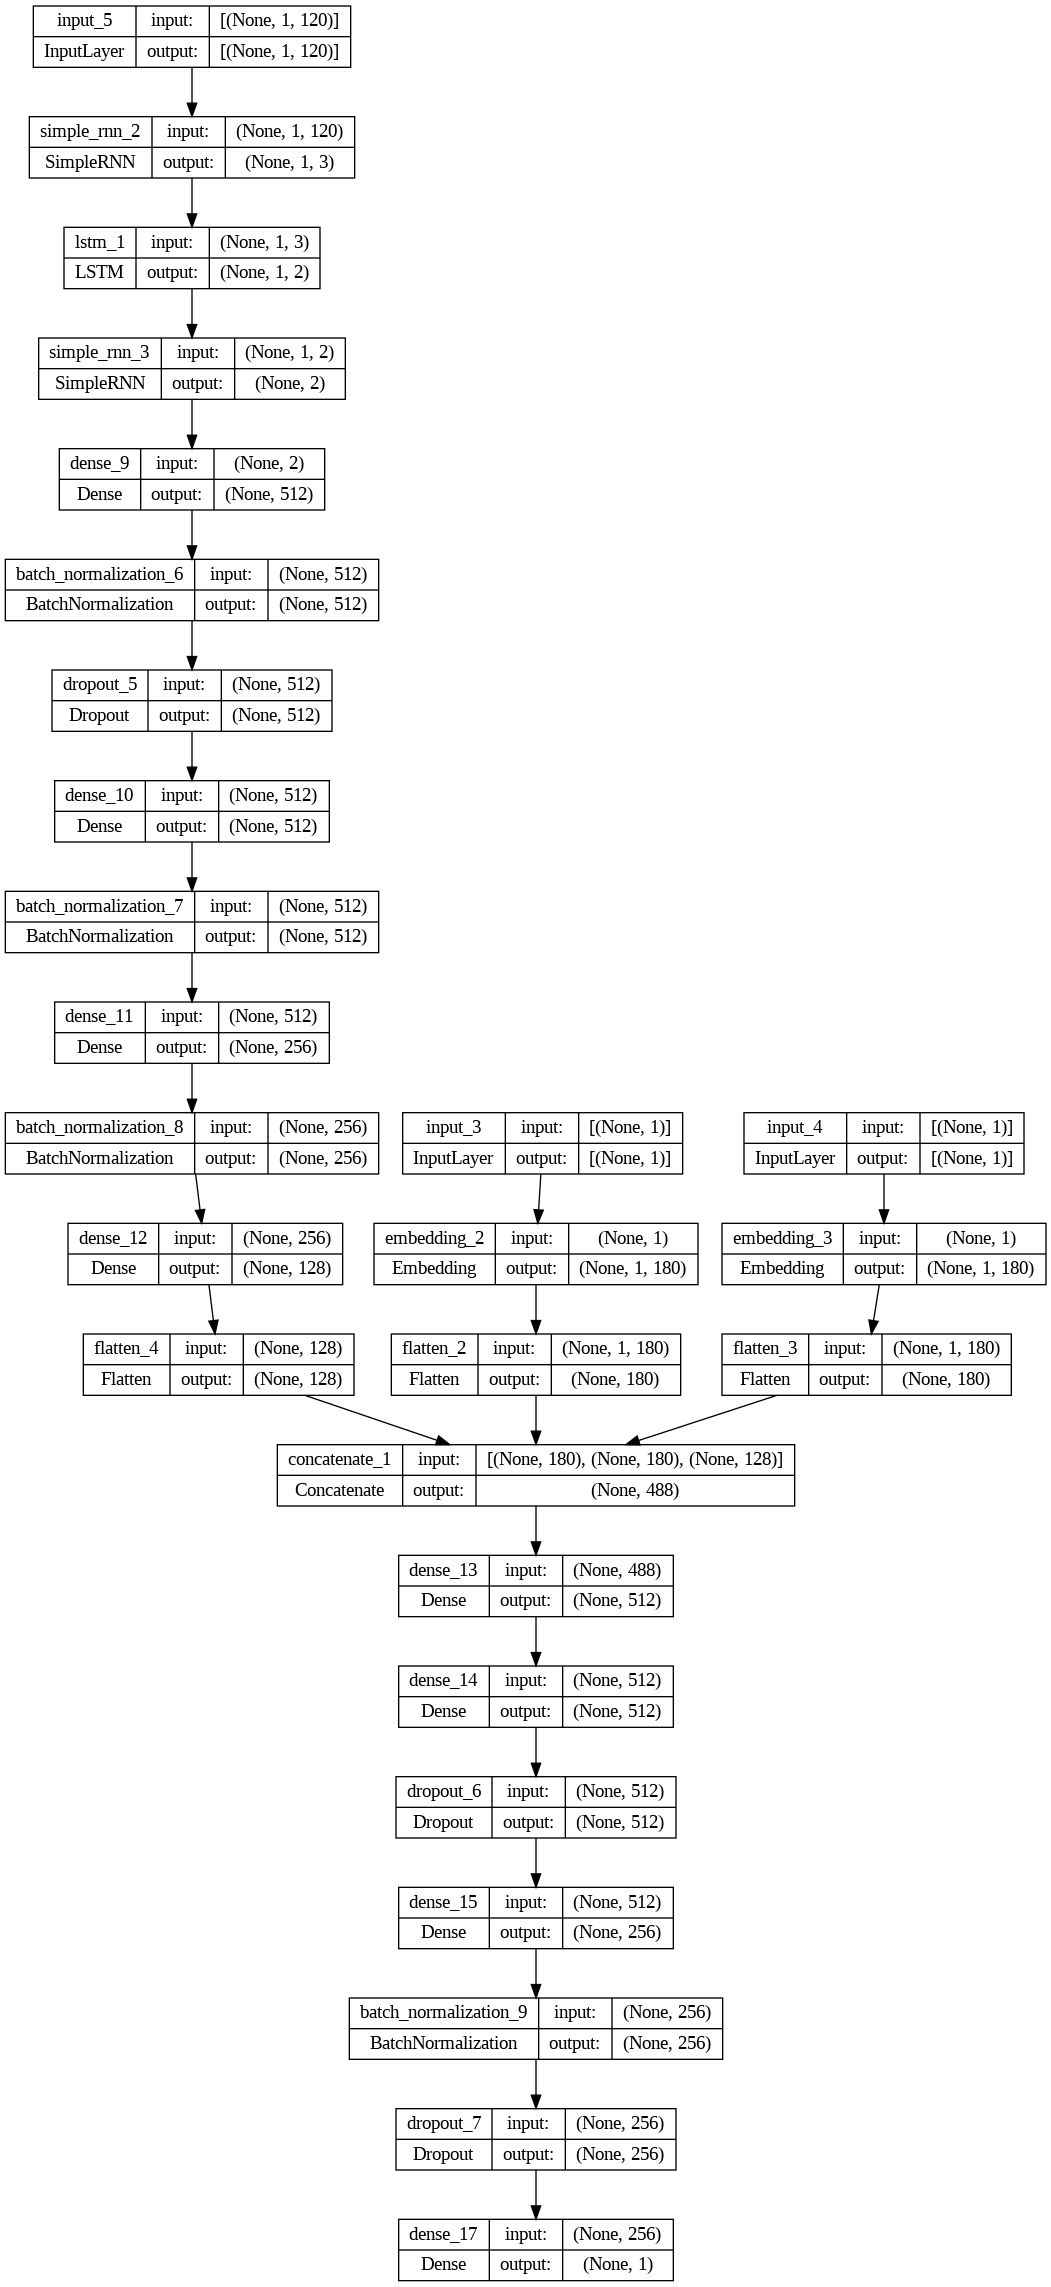

In [ ]:
plot_model(model_hybrid,show_shapes=True,to_file='deep learning model for hybrid model.png')

In [ ]:
X = data.drop(['rating','title'], axis=1)
Y = data['rating']

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size=0.2,random_state=23)
trainfet = feature_extract(xtrain)
testfet = feature_extract(xtest)

trainfet = trainfet.reshape((trainfet.shape[0],1,trainfet.shape[1]))
testfet = testfet.reshape((testfet.shape[0],1,testfet.shape[1]))

In [ ]:
history_h = model_hybrid.fit([xtrain['userId'],xtrain['movieId'],trainfet],
                    ytrain,
                    batch_size=128,
                    epochs=500,
                    validation_split=0.4)

Epoch 1/500
21/21 [==============================] - 13s 169ms/step - loss: 20.3796 - val_loss: 18.5797
Epoch 2/500
21/21 [==============================] - 1s 55ms/step - loss: 20.4039 - val_loss: 18.4856
Epoch 3/500
21/21 [==============================] - 1s 47ms/step - loss: 20.1411 - val_loss: 18.4294
Epoch 4/500
21/21 [==============================] - 1s 54ms/step - loss: 20.2517 - val_loss: 18.4152
Epoch 5/500
21/21 [==============================] - 1s 64ms/step - loss: 20.2289 - val_loss: 18.4349
Epoch 6/500
21/21 [==============================] - 1s 51ms/step - loss: 19.8442 - val_loss: 18.4662
Epoch 7/500
21/21 [==============================] - 1s 64ms/step - loss: 20.0506 - val_loss: 18.4767
Epoch 8/500
21/21 [==============================] - 1s 49ms/step - loss: 20.0016 - val_loss: 18.5130
Epoch 9/500
21/21 [==============================] - 1s 61ms/step - loss: 19.8004 - val_loss: 18.5487
Epoch 10/500
21/21 [==============================] - 1s 53ms/step - loss: 19.64

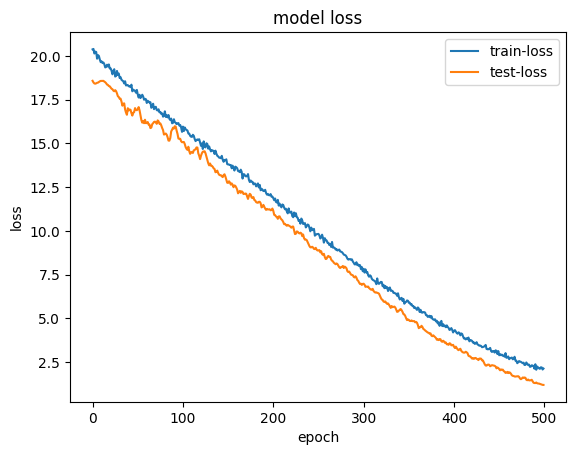

In [ ]:
# "Loss"
plt.plot(history_h.history['loss'])
plt.plot(history_h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'test-loss'], loc='upper right')
plt.show()

In [ ]:
userId = int(23)
user_ratings = data[data['userId'] == userId]
recommendation = data[~data['movieId'].isin(user_ratings['movieId'])][['movieId','title','genres']].drop_duplicates(subset='title', keep="first")
recommendation['userId'] = userId
rfet = feature_extract(recommendation)
rfet = rfet.reshape((rfet.shape[0],1,rfet.shape[1]))
recommendation['predicted_rating'] =model_hybrid.predict([recommendation['userId'],recommendation['movieId'],rfet])
recommendation = recommendation.merge(data[['title','movieId']],on='movieId')
recommendation = recommendation.drop_duplicates()
recommendation = recommendation.sort_values(by='predicted_rating', ascending=False).reset_index()
# recommend 5 products
results = recommendation[['title_x']].copy()
results = results.rename(columns={'title_x':'recommended movies'})
results.head(5)

10/10 [==============================] - 1s 3ms/step


,recommended movies
0,White Squall (1996)
1,Rob Roy (1995)
2,Bitter Moon (1992)
3,First Knight (1995)
4,Braveheart (1995)


#Analysis / Performance Comparison

analysis metrics are given below:
* mean absolute error
* mean squared error
* mean absolute percentage error



In [ ]:
result_1 = model_1.predict([xtest['userId'],xtest['movieId']])
result_2 = lstm_model.predict(testfet)
result_3 = model_hybrid.predict([xtest['userId'],xtest['movieId'],testfet])

35/35 [==============================] - 0s 3ms/step


In [ ]:
mae_1 = mean_absolute_error(result_1,ytest)
mse_1 = mean_squared_error(result_1,ytest)
mape_1 = mean_absolute_percentage_error(result_1,ytest)
r2_1 = r2_score(result_1,ytest)


In [ ]:
mae_2 = mean_absolute_error(result_2,ytest)
mse_2 = mean_squared_error(result_2,ytest)
mape_2 = mean_absolute_percentage_error(result_2,ytest)
r2_2 = r2_score(result_2,ytest)

In [ ]:
mae_3 = mean_absolute_error(result_3,ytest)
mse_3 = mean_squared_error(result_3,ytest)
mape_3 = mean_absolute_percentage_error(result_3,ytest)
r2_3 = r2_score(result_3,ytest)

In [ ]:
res = {
    'MODEL': ['Collaborative Filtering', 'Content-Based Filtering', 'Hybrid Model'],
    'MAE': [mae_1, mae_2, mae_3],
    'MSE': [mse_1, mse_2, mse_3],
    'MAPE': [mape_1, mape_2, mape_3]

}

df_metrics = pd.DataFrame(res)

# display dataframe
df_metrics.head()


,MODEL,MAE,MSE,MAPE
0,Collaborative Filtering,2.831967,8.304032,1.963884
1,Content-Based Filtering,3.946974,15.862925,10.307772
2,Hybrid Model,0.997890,1.260235,0.298992
